A practitioner’s manual for building LR systems using a data-driven approach
---



This python notebook accompanies the paper xxx. 

Follow along in the notebook by running the codeblocks pressing Shift+Enter on your keyboard.



The paper is a guideline to go from a data set to a validated Likelihood Ratio (LR) system in 8 steps. In this notebook, we go through each step using a glass data set, resulting in an LR system for glass. The guideline involves creating multiple LR systems at first, and selection of the best LR system in a later step. In this paper we explore two options to compute scores and two options to transform scores to LRs in a two-by-two design, leading to four LR systems.

The 'scorer' options are:
1. Use the Manhattan distance (defined as the sum of the absolute differences)
2. Use a support vector machine, a machine learning model

The 'calibrator' options are:
<ol type = 'A'>
<li>Use a generative approach, namely kernel density estimation</li>
<li>Use a discriminative approach, namely logistic regression</li>
</ol>



In [ ]:
%reset -f

### Loading Python packages

We start by installing several Python packages. These are standard packages, and the LiR package that we developed and maintain. This package provides a collection of scripts to aid construction and evaluation of LR systems.



In [ ]:
! pip install lir==0.1.21 
! pip install scipy==1.7.3
#! pip install pandas seaborn==0.11.2  # additional dependencies, already installed in Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 1.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from itertools import combinations
from random import choices
from random import seed
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import paired_manhattan_distances
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import lir

### Introduction lir and sklearn


LiR follows the conventions of the sklearn package, which is the de facto standard in machine learning. This has the advantage that we can directly use all models defined in sklearn and that the code will look familiar to anyone used to sklearn. It has the disadvantage that naming of certain functions and objects may appear counterintuitive to those unfamiliar with sklearn. Sklearn defines objects that can 'fit' on data, and then 'transform' new data or 'predict' probabilities. LiR additionally allows to 'predict_lr'. We will encounter examples of these below.

### Loading the data

We download the glass data in the form of a csv file and convert this to a pandas dataframe.

In [ ]:
csv_url = 'https://raw.githubusercontent.com/NetherlandsForensicInstitute/elemental_composition_glass/main/duplo.csv'
data_set = pd.read_csv(csv_url, delimiter=',').rename(columns = {'Item': 'Subject', 'Piece': 'Repeat', 'id': 'Id'})

# Step 1. Explore data




The data set we will use consists of elemental concentrations of floatglass, obtained with LA-ICPMS (a type of mass spectrometer) ([see github repository](https://github.com/NetherlandsForensicInstitute/elemental_composition_glass)). The elemental concentrations are on a 10 log basis, and normalized to the element Si. For each glass source, which we refer to as *subject*, two measurements are performed. Each time the concentration of ten elements is measured.

First, we will explore the type of data we have.

In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       640 non-null    int64  
 1   Subject  640 non-null    int64  
 2   Repeat   640 non-null    int64  
 3   K39      640 non-null    float64
 4   Ti49     640 non-null    float64
 5   Mn55     640 non-null    float64
 6   Rb85     640 non-null    float64
 7   Sr88     640 non-null    float64
 8   Zr90     640 non-null    float64
 9   Ba137    640 non-null    float64
 10  La139    640 non-null    float64
 11  Ce140    640 non-null    float64
 12  Pb208    640 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 65.1 KB


As can be seen there are 13 columns for each observation: 
- Id: a unique integer for each observation
- Subject: a unique integer for each subject
- Repeat: for each subject, a unique integer representing the repeated observations on this subject
- K39, Ti49, Mn55, Rb85, Sr88, Zr90, Ba137, La139, Ce140, Pb208: the processed concentration of the ten elements. The number behind the element in the column name specifies which isotope of the element was measured. The processed concentrations are all float numbers.

Furthermore, we see that there are no non-null values. In other words, there are no missing values.

Next, we have a look at the amount of data we have:

In [ ]:
print("Number of observations: ", data_set['Id'].nunique())
print("Number of subjects: ", data_set['Subject'].nunique())
print("Maximum number of repeated observations on one subject: ", data_set['Repeat'].nunique())

Number of observations:  640
Number of subjects:  320
Maximum number of repeated observations on one subject:  2


Above you can see the number of glass panes (=distinct source) and observations.

In this manual, we limit the number of items to ensure that we do not run out of RAM during the subsequent calculations.

In [ ]:
# Make sure that the sorting is first by item, then by repeat
data_set = data_set.sort_values(by=["Subject", "Repeat"], axis=0, ascending=True)

# Only keep the first 400 rows, as the free version of google colab does not have enough RAM available for computations on the full set
data_set = data_set.drop(data_set.index[400:])

Each row of the dataframe contains one observation:


In [ ]:
print(data_set.head())

   Id  Subject  Repeat       K39      Ti49      Mn55      Rb85      Sr88  \
0   1        1       1  2.632598  2.605259  2.256335  0.396947  1.792080   
1   2        1       2  2.650734  2.589055  2.302628  0.442676  1.767756   
2   3        2       1  2.961979  2.467961  2.182048  0.439477  1.710670   
3   4        2       2  2.945661  2.492296  2.179464  0.427490  1.757333   
4   5        3       1  2.960720  2.573878  2.071449  0.428202  1.717068   

       Zr90     Ba137     La139     Ce140     Pb208  
0  1.687005  1.636338  1.124591  1.518090  0.840343  
1  1.738677  1.615138  1.187096  1.516672  0.879644  
2  1.620326  1.626130  0.993176  1.338220  0.556401  
3  1.685472  1.616734  1.007451  1.290789  0.505195  
4  1.749157  1.808602  0.731249  1.000208  0.550739  




To get a bit more feeling for the data, we create a histogram of all observations per element together:


Histogram of all measured concentrations:


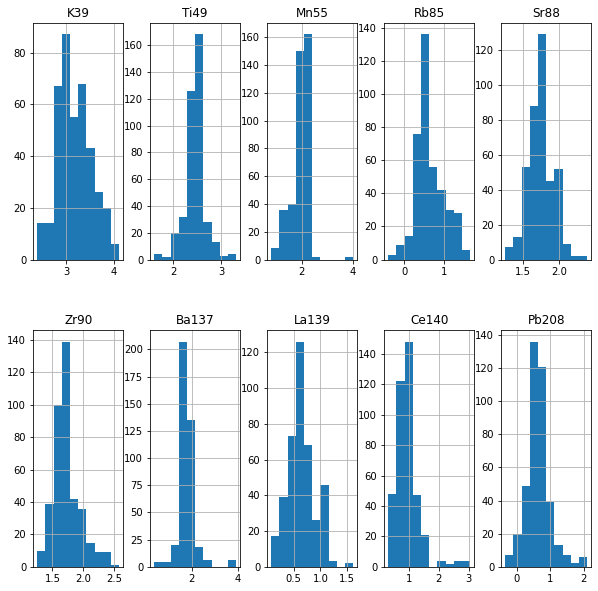

In [ ]:
print("Histogram of all measured concentrations:")
data_set[["K39", "Ti49", "Mn55", "Rb85", "Sr88", "Zr90", "Ba137", "La139", "Ce140",
        "Pb208"]].hist(figsize=(10,10), layout=(2,5));

In the histograms, we see that there are no distinctive outliers.

Now, we select the variables (the 10 elements) and labels (indicating which subject was measured) and convert them to a numpy array. This is the format needed for the rest of the steps. 

In [ ]:
variables = ["K39", "Ti49", "Mn55", "Rb85", "Sr88", "Zr90", "Ba137", "La139", "Ce140", "Pb208"]
labels = ["Subject"]

obs = data_set[variables].to_numpy()
ids = data_set[labels].to_numpy()

### Explore data - a deeper look

Looking at the data more closely, we see that the concentrations within an object appear closer to each other than the concentrations of different objects. To further examine this, we calculate the standard deviation within each glass object and compare it to the standard deviation of samples from different objects. For the latter, we take the mean of the two observations of each object.

Histograms of standard deviations within objects:


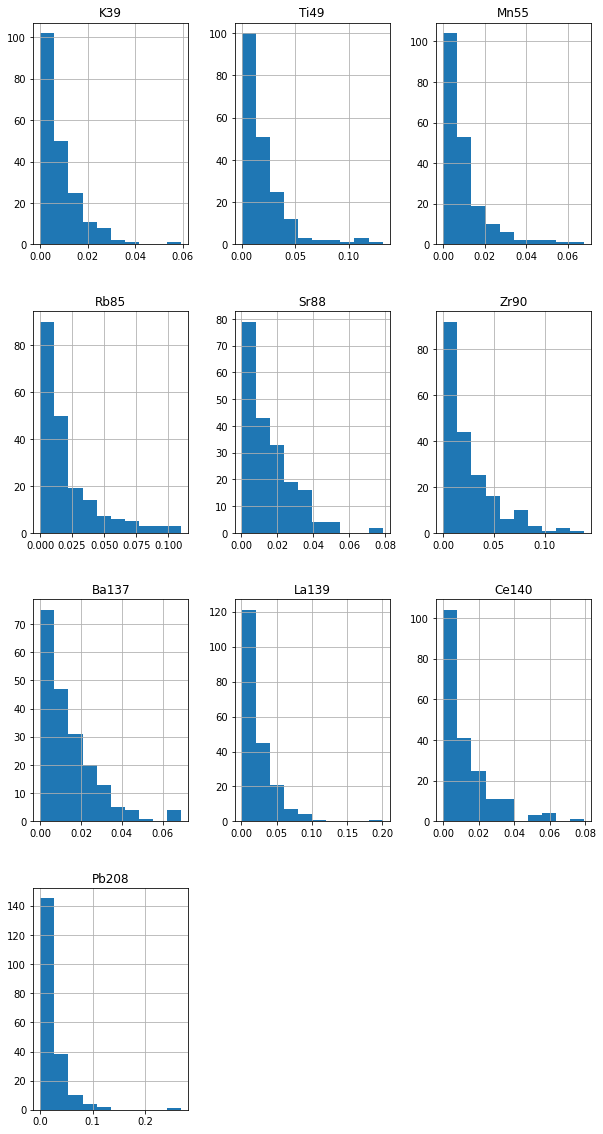

In [ ]:
print("Histograms of standard deviations within objects:")
data_set.groupby('Subject')[["K39", "Ti49", "Mn55", "Rb85", "Sr88",
                               "Zr90", "Ba137", "La139", "Ce140",
                               "Pb208"]].std().hist(figsize=(10,20));

In [ ]:
print("Standard deviations between glass objects compared to the maximum within standard deviation:")
st_devs = pd.DataFrame(data_set.groupby('Subject')[["K39", "Ti49", "Mn55", "Rb85", "Sr88",
                               "Zr90", "Ba137", "La139", "Ce140",
                               "Pb208"]].mean().std())
st_devs.columns = ['std_between']
st_devs['std_within_mean'] = pd.DataFrame(data_set.groupby('Subject')[["K39", "Ti49", "Mn55", "Rb85", "Sr88",
                               "Zr90", "Ba137", "La139", "Ce140",
                                    "Pb208"]].std().mean())
st_devs['std_within_max'] = pd.DataFrame(data_set.groupby('Subject')[["K39", "Ti49", "Mn55", "Rb85", "Sr88",
                               "Zr90", "Ba137", "La139", "Ce140",
                                    "Pb208"]].std().max())
st_devs


Standard deviations between glass objects compared to the maximum within standard deviation:


,std_between,std_within_mean,std_within_max
K39,0.342577,0.008472,0.059352
Ti49,0.211560,0.019630,0.131448
Mn55,0.355806,0.009783,0.067969
Rb85,0.348709,0.020834,0.110103
Sr88,0.173895,0.015366,0.078621
Zr90,0.216477,0.024599,0.139017
Ba137,0.370425,0.013874,0.069095
La139,0.249051,0.022618,0.200405
Ce140,0.406627,0.012323,0.079508
Pb208,0.359028,0.022336,0.268438


We see that the standard deviations of observations within glass objects roughly lie between 0 and 0.03 (second column), and the standard deviations of observations between objects are much larger (first column). In fact, the between objects standard deviation is larger than the largest with standard deviations we find (third column). This indicates that the output of an LR system based on this data can be discriminative.

When different variables are considered for calculating an evidential value, it is best when these variables have correlation close to 0. If two variables are highly correlated however, they can still both be used in the LR system; their combined within variance is reduced compared to measuring a single variable. If the number of variables is large compared to the number of objects, we may consider dimension reduction.

To see whether the concentrations of the different elements are correlated, we create scatterplots plotting the concentrations against each other.

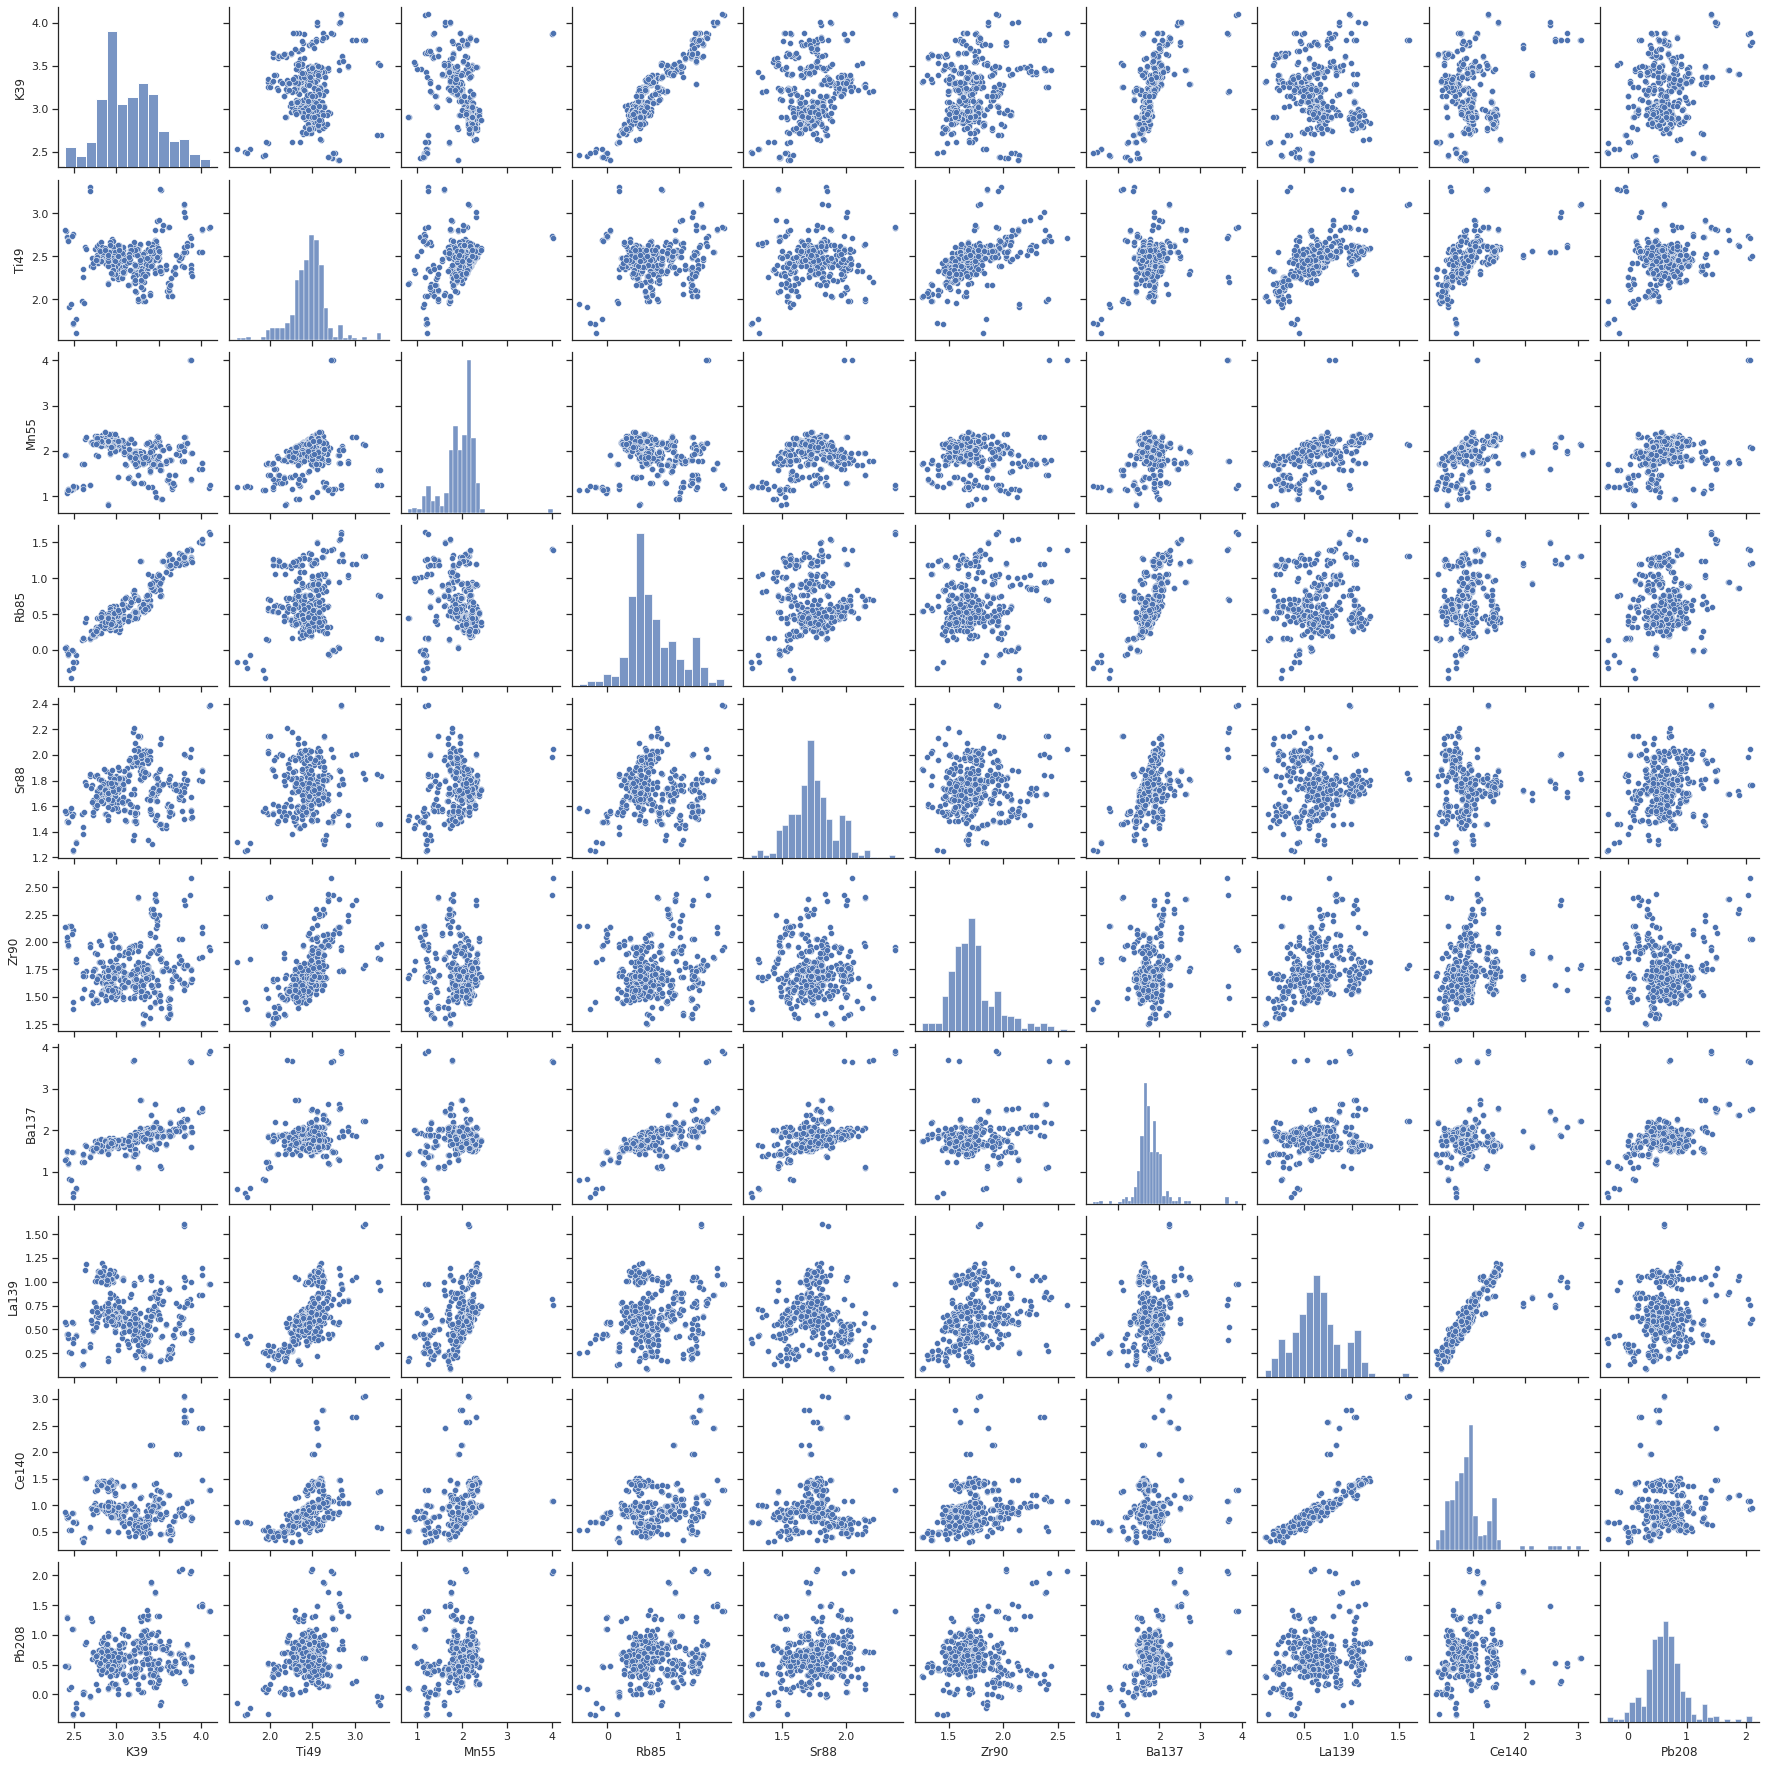

In [ ]:
import seaborn as sns
sns.set_theme(style='ticks')

sns.pairplot(data_set.reset_index()[["K39", "Ti49", "Mn55", "Rb85", "Sr88", "Zr90", "Ba137", "La139", "Ce140", "Pb208"]
])
plt.show()
plt.clf()
plt.close()

We see that some of the values are correlated, for example for K39 and Rb85. Most scatterplots seem quite random, indicating a low correlation. This is indeed reflected in the correlation matrix:

In [ ]:
corr = data_set[["K39", "Ti49", "Mn55", "Rb85", "Sr88", "Zr90", "Ba137", "La139", "Ce140", "Pb208"]].corr()
corr.style.background_gradient()

,K39,Ti49,Mn55,Rb85,Sr88,Zr90,Ba137,La139,Ce140,Pb208
K39,1.000000,0.067055,-0.127568,0.935838,0.252946,0.098428,0.653097,-0.071568,0.138057,0.247101
Ti49,0.067055,1.000000,0.267245,0.155035,0.102537,0.503558,0.224503,0.610159,0.523428,0.229031
Mn55,-0.127568,0.267245,1.000000,-0.065061,0.184014,-0.039307,0.148426,0.511505,0.356001,0.286841
Rb85,0.935838,0.155035,-0.065061,1.000000,0.097745,0.131032,0.648316,0.116004,0.274328,0.268985
Sr88,0.252946,0.102537,0.184014,0.097745,1.000000,0.067813,0.518871,-0.030820,-0.043135,0.246441
Zr90,0.098428,0.503558,-0.039307,0.131032,0.067813,1.000000,0.189331,0.292032,0.232167,0.154067
Ba137,0.653097,0.224503,0.148426,0.648316,0.518871,0.189331,1.000000,0.106475,0.131475,0.548194
La139,-0.071568,0.610159,0.511505,0.116004,-0.030820,0.292032,0.106475,1.000000,0.807132,0.203315
Ce140,0.138057,0.523428,0.356001,0.274328,-0.043135,0.232167,0.131475,0.807132,1.000000,0.112706
Pb208,0.247101,0.229031,0.286841,0.268985,0.246441,0.154067,0.548194,0.203315,0.112706,1.000000


The results above encourage us to create an LR system based on the processed concentrations of the 10 elements in glass.

# Step 2. Split data in different subsets


As explained in the manuscript, splitting the data is a necessary step in order to evaluate the performance of the model while avoiding overfitting. This means that part of the data will be used to build the model (train and selection sets) and another part is reserved for validation.

As shown in the steps below, all three sets should be independent, e.g. consist of disjoint sets of glass objects. First, we set 20% of the objects aside for the validation set, and then we split the remaining objects into training (80%) and selection (20%) sets. 

In [ ]:
# First we split off 20% from the data for a hold-out validation set (grouped per glass particle)
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state=1)
split = splitter.split(obs, groups=ids)
train_select_indices, val_indices = next(split)

# Then we split off 20% to use as a test set
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state=1)
split = splitter.split(obs[train_select_indices], groups=ids[train_select_indices])
train_indices, select_indices = next(split)

# We create the train, selection and validation sets
# obs are the concentrations, ids are the corresponding labels indicating the source item
ids_train = ids[train_indices]
ids_select = ids[select_indices]
ids_val = ids[val_indices]
obs_train = obs[train_indices]


# show the sizes of the data sets
print(len(obs))

print(len(ids_train))
print(len(ids_select))
print(len(ids_val))

400
256
64
80


# Step 3. Pre-process data

This step entails transformation of the raw data to informative features that can be used by a statistical model. Standard transformations for concentration data are taking the log10 and normalising by a certain variable (in this particular example: dividing all other variables by the value of Si), both of which are already applied per observation to the glass data we use.

To show another example of preprocessing, in addition we here apply a z-score transformation per column to the data set: substracting the mean and dividing by the standard deviation.

In [ ]:
z_score_transformer = StandardScaler()
z_score_transformer.fit(obs_train)
obs_zscore = z_score_transformer.transform(obs)

We can see what this transformation does for one of the columns in the figures below. The distribution is scaled and shifted, but otherwise the same.

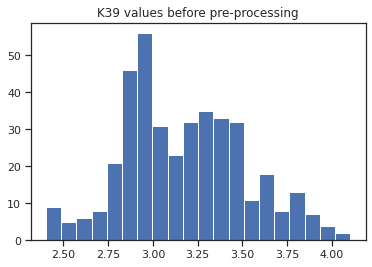

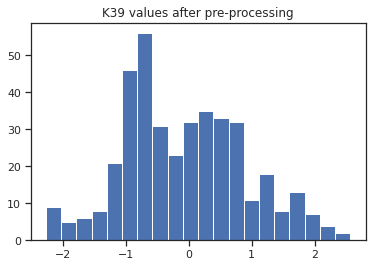

In [ ]:
plt.hist(obs[:,0], bins = 20);
plt.title('K39 values before pre-processing')
plt.figure()
plt.hist(obs_zscore[:,0], bins = 20);
plt.title('K39 values after pre-processing');

# Step 4. Calculate scores

In the previous steps we have explored the given data, split it into subsets and performed pre-processing. We call the 10 pre-processed values we now have for each observation the features. The next step is to go from these features to a score. In order to do this we have to make pairs of observations, both *H*<sub>1</sub>-true and *H*<sub>2</sub>-true, and calculate the scores based on their features. A score is meant to quantify the degree of (dis)similarity between a pair of observations. 


### Create pairs

The function `create_pairs` below creates one *H*<sub>1</sub>-true pair per subject, and one *H*<sub>2</sub>-true pair for each pair of different subjects. 

In [ ]:
def create_pairs(obs, ids):
    """
    creates all possible pairs between the items represented by ids
    the ids refer to the total set of observations given by obs.
    """
    # Create matrices with item IDs that refer to the total data set
    H1_ids = np.transpose(np.tile(np.unique(ids), (2, 1)))
    H2_ids = np.asarray(list(combinations(np.unique(ids), 2)))

    # For H1-data: use the first repeat for each item in the first colum,
    # and the second repeat of that item in the second.
    # It is assumed: that obs is sorted first by item ID, then by repeat ID; 
    # that all items have exactly 2 repeats; that there are no missing items.
    H1_obs_rep_1 = obs[2*H1_ids[:,0] - 2]
    H1_obs_rep_2 = obs[2*H1_ids[:,1] - 1]
    H1_obs_pairs = np.stack((H1_obs_rep_1, H1_obs_rep_2), axis=2)

    # For H2-data: use for both items their first repeats
    H2_obs_item_1 = obs[2*H2_ids[:,0] - 2]
    H2_obs_item_2 = obs[2*H2_ids[:,1] - 2]
    H2_obs_pairs = np.stack((H2_obs_item_1, H2_obs_item_2), axis=2)

    # Combine the H1 and H2 data, and create vector with classes: H1=1 & H2=0
    obs_pairs = np.concatenate((H1_obs_pairs, H2_obs_pairs))
    H1_same_source = np.ones(H1_ids.shape[0])
    H2_same_source = np.zeros(H2_ids.shape[0])
    same_source = np.concatenate((H1_same_source, H2_same_source))

    return obs_pairs, same_source

We create the pairs for the subjects in the train data and the selection data.

In [ ]:
obs_pairs_train, same_source_train = create_pairs(obs_zscore, ids_train)
obs_pairs_select, same_source_select = create_pairs(obs_zscore, ids_select)


Once we have the same-source and different-source pairs we have to compute the score per pair. We show two different ways. 

### Option 1: Compute (dis)similarity score 
We take the Manhattan distance, also called *L*<sub>1</sub>-norm. This is defined as the of the absolute differences of the features. Luckily, distances such as these are standard functions in the python package sklearn.

In [ ]:
dissimilarity_scores_train = paired_manhattan_distances(obs_pairs_train[:,:,0], obs_pairs_train[:,:,1])
dissimilarity_scores_select = paired_manhattan_distances(obs_pairs_select[:,:,0], obs_pairs_select[:,:,1])


### Option 2: Compute machine learning score
Alternatively, we can fit a statistical model to compute scores. In this case, we use a support vector machine. First the absolute differences for each elemental value between the pairs of observations are computed. The support vector machine then assigns a score to each pair. The model aims to assign high scores to *H*<sub>1</sub>-true pairs and low scores to *H*<sub>2</sub>-true pairs.

In [ ]:
from lir.transformers import AbsDiffTransformer

# machine learning models need a single vector as input. The AbsDiffTransformer takes two feature vectors, one for each subject of a pair, and returns the elementwise absolute differences
# The AbsDiffTransformer and support vector machine (SVC) are combined into a single pipeline using sklearns Pipeline class.
machine_learning_scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

# the model has to be fit on the data
machine_learning_scorer.fit(obs_pairs_train, same_source_train)
# score can be computed using the 'predict_proba' function. This is another sklearn convention, which returns two columns of which we take the second using '[:,1]'
machine_learning_scores_train = machine_learning_scorer.predict_proba(obs_pairs_train)[:,1]

The scores look like this:

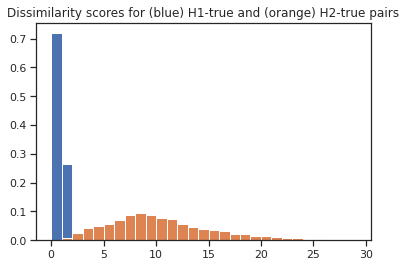

In [ ]:
plt.figure();
plt.hist(dissimilarity_scores_train[same_source_train==1], density=True, bins=range(30))
plt.hist(dissimilarity_scores_train[same_source_train==0], density=True, bins=range(30));
plt.title('Dissimilarity scores for (blue) H1-true and (orange) H2-true pairs');


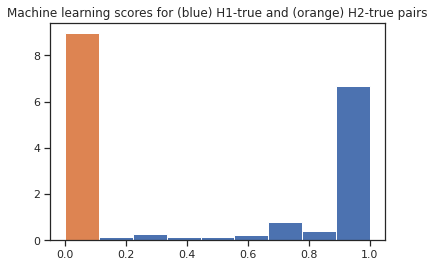

In [ ]:
plt.figure();
plt.hist(machine_learning_scores_train[same_source_train==1], density=True, bins=np.linspace(0, 1, 10))
plt.hist(machine_learning_scores_train[same_source_train==0], density=True, bins=np.linspace(0, 1, 10));
plt.title('Machine learning scores for (blue) H1-true and (orange) H2-true pairs');


As expected, the *H*<sub>1</sub>-true pairs generally have lower dissimilary scores than the *H*<sub>2</sub>-true pairs, while their machine learning scores are higher.

#Step 5. Calculate LRs from scores

After step 4 we have a score for each pair. Two approaches exist to convert these scores to LRs. We show an example for each approach.



### Generative approach

In the generative approach approach, we model the distribution of scores under *H*<sub>1</sub> and under *H*<sub>2</sub>. Here, we use kernel density estimation (KDE) to do this. Lir defines classes called 'Calibrators' to perform the score to LR mapping.

In [ ]:
kde_calibrator = lir.KDECalibrator(bandwidth='silverman')

To illustrate how this works, we plot the histogram for the scores under *H*<sub>1</sub> and *H*<sub>2</sub>-true, together with the KDE fits.


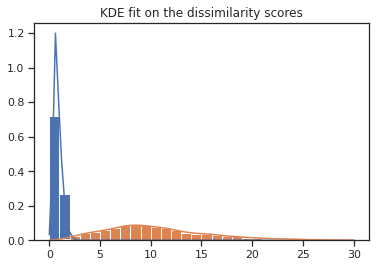

In [ ]:
kde_calibrator.fit(dissimilarity_scores_train, same_source_train)
with lir.plotting.show() as ax:
    ax.calibrator_fit(kde_calibrator, score_range=[0,30]);
    ax.hist(dissimilarity_scores_train[same_source_train==1], density=True, bins=range(30), color='C0');
    ax.hist(dissimilarity_scores_train[same_source_train==0], density=True, bins=range(30), color='C1');
    ax.title('KDE fit on the dissimilarity scores');

### Discriminative approach
Alternatively, we can use other discriminative methods. Here we use logistic regression to map the score to posterior odds. This can be corrected for the amount of *H*<sub>1</sub> and *H*<sub>2</sub> data.

In [ ]:
logreg_calibrator = lir.LogitCalibrator()

### Bounding the LRs

The LR system may output values that seem too large or too small given the size of our data set. Several methods have been proposed mitigate this problem, by 'shrinking' the LRs towards 1. Here we show how to use empirical lower and upper bounds (ELUB) to limit the minimum and maximum values the LR system can output. Using lir, we can stack this 'ELUBbounder' on any calibrator we have.

In [ ]:
bounded_kde_calibrator = lir.ELUBbounder(kde_calibrator)
bounded_logreg_calibrator = lir.ELUBbounder(logreg_calibrator)

### Illlustration of scores to LRs
To illustrate the score to LR mapping, we plot how the dissimilarity scores are mapped to LRs (using a log scale). We print the values of the ELUB bounds - these are visible in the plot as the minimum and maximum values the LRs obtain (horizontal lines).

One thing to note is that the blue line (logistic regression) never goes up. This is a desirable property, it makes sense that more extreme scores correspond to more extreme LRs. In contrast, the orange line (KDE) shows several humps, e.g. at score=0 and score=2. This means that counterintuitively, sometimes a higher dissimilarit leads to a lower LR. Here we don't 'fix' this (e.g. by adjusting the bandwidth of the KDE), but be aware that some methods for transforming scores to LRs can have this property.

ELUB log LR bounds for logreg are -2.09 and 3.29
ELUB log LR bounds for kde are -2.10 and 2.50


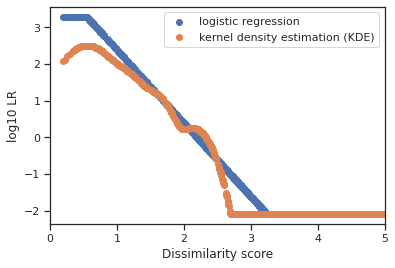

In [ ]:
lrs_train_logreg = bounded_logreg_calibrator.fit_transform(dissimilarity_scores_train, same_source_train)
lrs_train_kde = bounded_kde_calibrator.fit_transform(dissimilarity_scores_train, same_source_train)

plt.scatter(dissimilarity_scores_train, np.log10(lrs_train_logreg), label='logistic regression')
plt.scatter(dissimilarity_scores_train, np.log10(lrs_train_kde), label = 'kernel density estimation (KDE)')
plt.xlim([0,5])

plt.legend()

plt.xlabel('Dissimilarity score')
plt.ylabel('log10 LR')
print(f'ELUB log LR bounds for logreg are {np.log10(bounded_logreg_calibrator._lower_lr_bound):.2f} and {np.log10(bounded_logreg_calibrator._upper_lr_bound):.2f}')
print(f'ELUB log LR bounds for kde are {np.log10(bounded_kde_calibrator._lower_lr_bound):.2f} and {np.log10(bounded_kde_calibrator._upper_lr_bound):.2f}')

# Step 6. Select best LR system



In this step, we compute the performance of each LR system defined on the selection data. For this we use the CalibratedScorer class from lir, which allows you to combine computing scores and transforming to LRs in one step. A CalibratedScorer needs two parts: a function or machine learning model to compute scores, and a Calibrator to transform the scores to LRs

We use the following two plots and metrics: 

In [ ]:
def show_performance(lrs, same_source, calibrator):
  # show the distribution of LRs together with the ELUB values
  with lir.plotting.show() as ax:
      ax.lr_histogram(lrs, same_source)
      ax.title('Histogram of H1-true (orange) and H2-true (blue) LRs')

  print(f'\n ELUB log LR bounds are {np.log10(calibrator._lower_lr_bound):.2f} and {np.log10(calibrator._upper_lr_bound):.2f} \n')

  # show the PAV plot (closer to the line y=x is better)
  with lir.plotting.show() as ax:
      ax.pav(lrs, same_source)

  # print the quality of the system as log likelihood ratio cost (lower is better)
  print(f'\n The log likelihood ratio cost is {lir.metrics.cllr(lrs, same_source):.3f} (lower is better)\n')

### Option 1: Manhattan distance + KDE



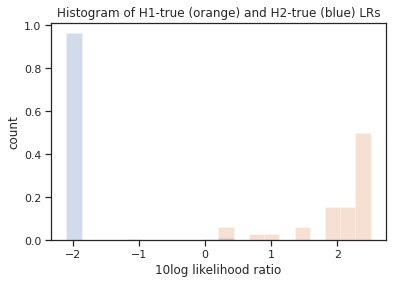


 ELUB log LR bounds are -2.10 and 2.50 



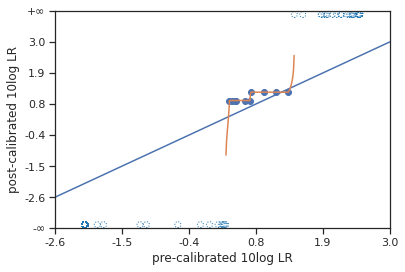


 The log likelihood ratio cost is 0.060 (lower is better)



In [ ]:
# we define the CalibratedScorer. We use the standard sklearn function paired_manhattan_distance to compute the scores,
# and an ELUB bounded KDE calibrator to transform to LRs.
lr_system = lir.CalibratedScorer(paired_manhattan_distances, bounded_kde_calibrator)
# We fit the entire lr system
lr_system.fit(obs_pairs_train, same_source_train)

# and compute the LRs on the selection data
lrs_select = lr_system.predict_lr(obs_pairs_select)

# this is how well the system performs
show_performance(lrs_select, same_source_select, lr_system.calibrator)

### Option 2: Manhattan distance + logistic regression

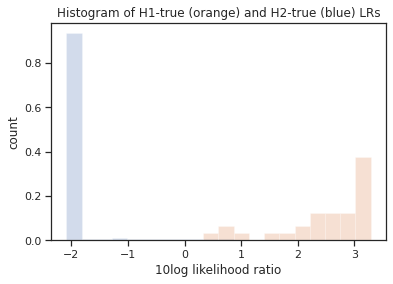


 ELUB log LR bounds are -2.09 and 3.29 



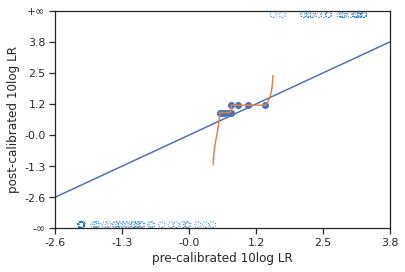


 The log likelihood ratio cost is 0.052 (lower is better)



In [ ]:
# we define the CalibratedScorer. We use the standard sklearn function paired_manhattan_distance to compute the scores,
# and an ELUB bounded logistic regression calibrator to transform to LRs.
lr_system = lir.CalibratedScorer(paired_manhattan_distances, bounded_logreg_calibrator)
# We fit the entire lr system
lr_system.fit(obs_pairs_train, same_source_train)

# and compute the LRs on the selection data
lrs_select = lr_system.predict_lr(obs_pairs_select)

# this is how well the system performs
show_performance(lrs_select, same_source_select, lr_system.calibrator)

### Option 3: support vector machine + KDE



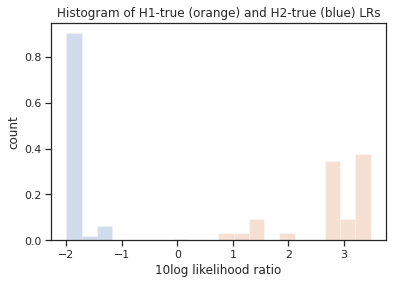


 ELUB log LR bounds are -2.00 and 3.48 



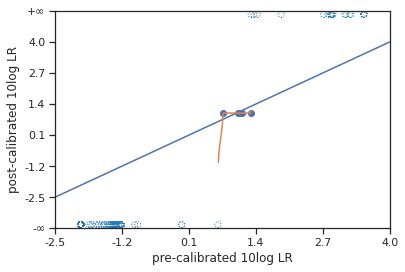


 The log likelihood ratio cost is 0.035 (lower is better)



In [ ]:
# The whole LR system consists of computing the score and then mapping the scores to lrs
# we use the machine learning scorer introduced in step 4
scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

lr_system = lir.CalibratedScorer(scorer, bounded_kde_calibrator)

# we fit the whole system. When fitting (=training) a CalibratedScorer, both the machine learning model and the transformation to LRs are trained on the supplied data
lr_system.fit(obs_pairs_train, same_source_train)
lrs_select = lr_system.predict_lr(obs_pairs_select)


show_performance(lrs_select, same_source_select, lr_system.calibrator)


### Option 4: support vector machine + logistic regression


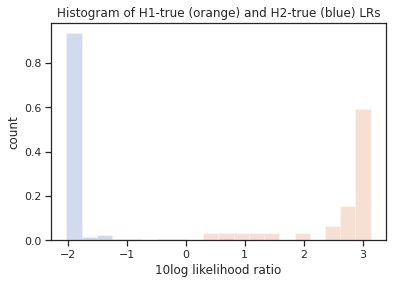


 ELUB log LR bounds are -2.03 and 3.14 



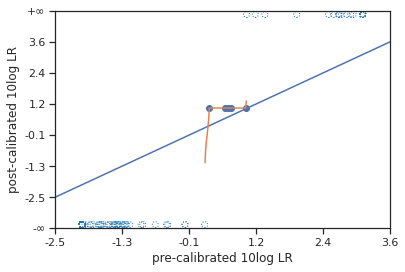


 The log likelihood ratio cost is 0.040 (lower is better)



In [ ]:
# The whole LR system consists of computing the score and then mapping the scores to lrs
scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

lr_system = lir.CalibratedScorer(scorer, bounded_logreg_calibrator)
# we fit the whole system
lr_system.fit(obs_pairs_train, same_source_train)
lrs_select = lr_system.predict_lr(obs_pairs_select)

show_performance(lrs_select, same_source_select, lr_system.calibrator)

### Final selection
All four options show reasonable LR distributions. Because the glass data contain much information the *H*<sub>1</sub> and *H*<sub>2</sub> are perfectly separated. Most of the *H*<sub>2</sub> pairs, and many of the *H*<sub>1</sub> pairs fall on the ELUB bounds. We see similar performance across the four systems. The LR distributions look reasonable for all systems, the PAV plots look good for options 2 and 3 (with the points following the line y=x) and show slightly conservative LRs for options 1 and 4 (points lying above the line y=x).

We have a slight preference for option 3, which has a good PAV plot, the best (=lowest) *C*<sub>llr</sub> and best (=widest) ELUB bounds. Option 2 would also have been a reasonable choice, particularly as the Manhattan distance is much more explainable than the support vector machine.

# Step 7. Validate selected LR system


After selecting the (best) model, you should assess the performance of the system on the validation set.

### Construct the selected system

Since we want to build the final model based on as much data as possible, we combine the train and selection set and use this to train the final LR system.

In [ ]:
# create the combined data set
obs_train_select = obs[train_select_indices]
ids_train_select = ids[train_select_indices]

# step 3 pre-processing: normalise
z_score_transformer.fit(obs_train_select)
obs_zscore = z_score_transformer.transform(obs)

# step 4: combine the pairs into one feature vector by taking the absolute difference
obs_pairs_train_select, same_source_train_select = create_pairs(obs_zscore, ids_train_select)
obs_pairs_val, same_source_val = create_pairs(obs_zscore, ids_val)

selected_lr_system = lir.CalibratedScorer(machine_learning_scorer, lir.ELUBbounder(lir.KDECalibrator()))
# step 4+5 combined: we fit the whole system
selected_lr_system.fit(obs_pairs_train_select, same_source_train_select)

# compute the LRs on the validation data
lrs_val = selected_lr_system.predict_lr(obs_pairs_val)

/usr/local/lib/python3.8/dist-packages/lir/calibration.py:169: UserWarning: missing bandwidth argument for KDE, defaulting to silverman (default argument will be removed in the future)
  warnings.warn("missing bandwidth argument for KDE, defaulting to silverman (default argument will be removed in the future)")


### Calculate system performance

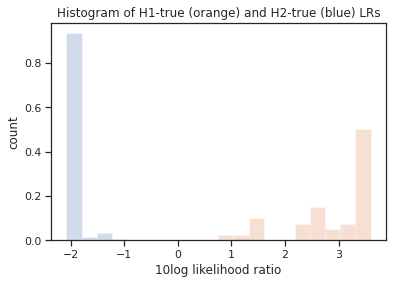


 ELUB log LR bounds are -2.08 and 3.60 



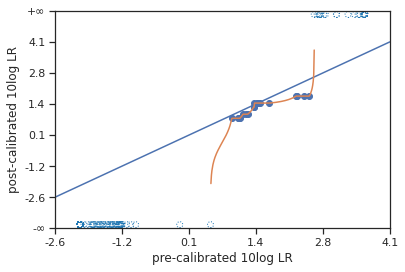


 The log likelihood ratio cost is 0.043 (lower is better)



In [ ]:
# we always inspect the characteristics we also look at in selection
show_performance(lrs_val, same_source_val, selected_lr_system.calibrator)

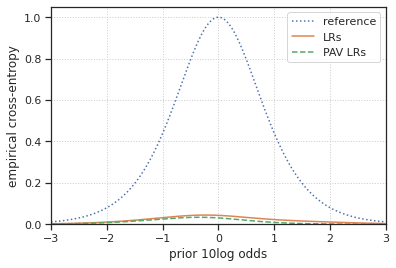

In [ ]:
# There are many other characteristics that we may want to inspect, such as the empirical cross entropy (ECE) plot.
with lir.plotting.show() as ax:
      ax.ece(lrs_val, same_source_val)

In the validation, we hope to see performance comparable to that on the selection data. This is the case here, with  *C*<sub>llr</sub>, ELUB bounds and LR distributions looking very similar to those we saw in step 6. The PAV plot looks reasonable, with the data points mostly following the line y=x. There are a few datapoint that lie under this line, indicating a slight overconfidence of the system in this LR range.



# Step 8. Construct casework LR system


To obtain our casework LR system, we fit on all available data

In [ ]:
# create new pairs for the combined data
obs_zscore = z_score_transformer.fit_transform(obs)
obs_pairs, same_source = create_pairs(obs_zscore, ids)

# fit the same system on all the data
selected_lr_system.fit(obs_pairs, same_source);

Note that we can not empirically test this system. In casework, if you have decided to use the system, you would input your pair of observation and get back an LR.

In [ ]:
observation_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
observation_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

manual_entered_data = np.moveaxis(np.array([z_score_transformer.transform([observation_1,observation_2])]),1,-1)

print(f'The LR obtained is {selected_lr_system.predict_lr(manual_entered_data)[0]}')

The LR obtained is 7186.790735833397


# TODO Putting it all together (a full pipeline?)

In the notebook so far we have separated the different steps. In practice, we use code that is more concise and readable, which also allows us to automatically assess the different options we have defined. This section shows how to do that.